In [1]:
import numpy as np 
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go


In [2]:
def compute_call_BS(S0, T, K, sigma, r, q=0, t=0):
    d_plus = (1./(sigma*np.sqrt(T-t)))*np.log(S0/(K*np.exp(-(r-q)*(T-t)))) + 0.5*sigma*np.sqrt(T-t)
    d_moins = d_plus - sigma*np.sqrt(T-t)
    call = S0*np.exp(-q*(T-t))*norm.cdf(d_plus) - K*np.exp(-r*(T-t))*norm.cdf(d_moins)
    return call

In [3]:
def simulate_asian_call(N_trajectories, N_sample_points, confidence, S0, T, strike, sigma, r):
    A_k = np.array([ T*(2*(k-N_sample_points)+1)/(2*N_sample_points) for k in range(1,N_sample_points+1)])
    delta_w = np.random.normal(loc = 0., scale = np.sqrt(T/N_sample_points), size = (N_trajectories,N_sample_points))
    means = (A_k*delta_w).sum(axis = 1)
    W_t_sample_paths = np.cumsum(delta_w, axis = 1)
    X_t_sample_paths = S0*np.exp((r- 0.5*sigma*sigma)*T + sigma*W_t_sample_paths)
    int_W_T = np.random.normal(loc = means, scale= T/(12.*N_sample_points))
    k_T = np.maximum(S0*np.exp(-(0.5*r + sigma*sigma/12.)*T)*np.exp((r- 0.5*sigma*sigma/3)*T + sigma*int_W_T) - strike, 0)
    int_X_T = (1./N_sample_points)*X_t_sample_paths.sum(axis = 1)
    call_X_T = np.maximum(int_X_T - strike,0)
    
    diff_price = call_X_T - k_T
    
    call_price_BS = np.exp(r*T)*compute_call_BS(S0 = S0*np.exp(-(0.5*r + sigma*sigma/12.)*T),
                                                             T = T, 
                                                             K = strike, 
                                                             sigma = (sigma/np.sqrt(3)),
                                                             r = r)
    price_controled = np.mean(diff_price) + call_price_BS
    price_X_T = np.mean(call_X_T)
    std_controled = np.std(diff_price)
    confidence_interval_size_controled = (norm.ppf((1.+confidence)/2.)*std_controled)**2.0/N_trajectories
    std = np.std(call_X_T)
    confidence_interval_size = (norm.ppf((1.+confidence)/2.)*std)**2.0/N_trajectories
    return price_controled, price_X_T,  confidence_interval_size_controled, confidence_interval_size
    

In [5]:
simulate_asian_call(N_trajectories = 100000, 
                    N_sample_points = 300, 
                    confidence = 0.95, 
                    S0 = 100,
                    T = 1.0, 
                    strike = 95, 
                    sigma = 0.1, 
                    r = 0.02)

(7.095665162590609,
 7.087780203664482,
 0.004070194209608898,
 0.0011124723530987393)

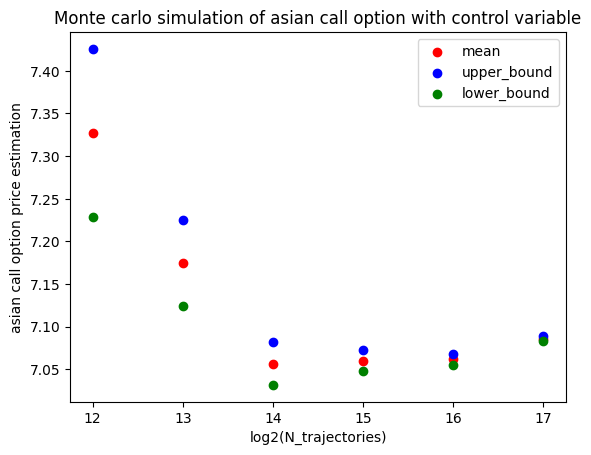

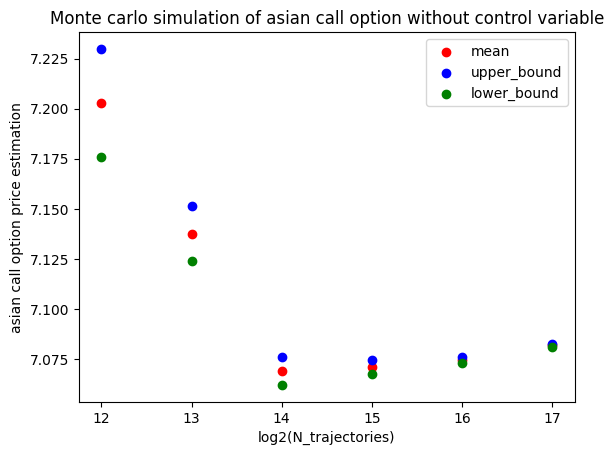

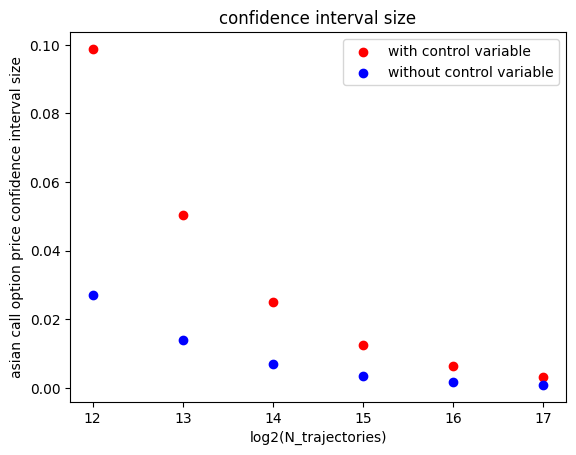

In [4]:
X = [int(2**k) for k in range(12,18)]
Y = [simulate_asian_call(N_trajectories = x, 
                    N_sample_points = 200, 
                    confidence = 0.95, 
                    S0 = 100,
                    T = 1.0, 
                    strike = 95, 
                    sigma = 0.1, 
                    r = 0.02) for x in X]

estimation = np.array([y[0] for y in Y])
confidence_1 = np.array([y[2] for y in Y])

X_1 = range(12,18)
plt.scatter(X_1, estimation, c = 'red', label = 'mean')
plt.scatter(X_1, estimation+confidence_1, c = 'blue', label = 'upper_bound')
plt.scatter(X_1, estimation-confidence_1, c = 'green', label = 'lower_bound')
plt.title('Monte carlo simulation of asian call option with control variable')
plt.xlabel('log2(N_trajectories)')
plt.ylabel('asian call option price estimation')
plt.legend()
plt.figure()

estimation = np.array([y[1] for y in Y])
confidence = np.array([y[3] for y in Y])

X_1 = range(12,18)
plt.scatter(X_1, estimation, c = 'red', label = 'mean')
plt.scatter(X_1, estimation+confidence, c = 'blue', label = 'upper_bound')
plt.scatter(X_1, estimation-confidence, c = 'green', label = 'lower_bound')
plt.title('Monte carlo simulation of asian call option without control variable')
plt.xlabel('log2(N_trajectories)')
plt.ylabel('asian call option price estimation')
plt.legend()


plt.figure()
plt.scatter(X_1, confidence_1, c = 'red', label = 'with control variable')
plt.scatter(X_1, confidence, c = 'blue', label = 'without control variable')
plt.title('confidence interval size')
plt.xlabel('log2(N_trajectories)')
plt.ylabel('asian call option price confidence interval size')
plt.legend()